In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

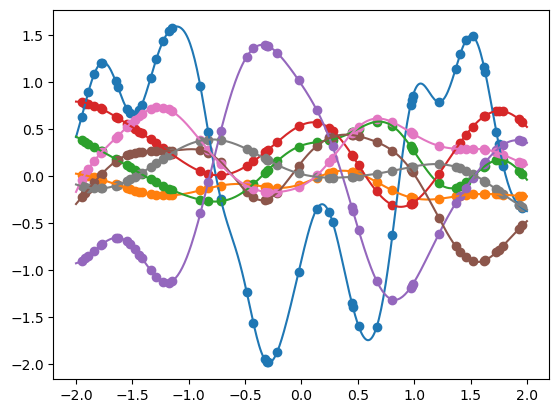

In [94]:
from data.gpdata_new import GPData
import matplotlib.pyplot as plt

sine_data_test = GPData(max_num_context=97, sigma_noise=5e-5)

batch = sine_data_test.generate_batch(batch_size=8, testing=True, device='cpu')

for i in range(8):
    x_target = batch.target_x[i].flatten()
    y_target = batch.target_y[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy())
for i in range(8):
    x_context = batch.context_x[i].flatten()
    y_context = batch.context_y[i].flatten()
    plt.scatter(x_context.numpy(), y_context.numpy())
plt.show()

In [30]:
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

def loss_function(pred_dist: Normal, 
                  target_y: torch.Tensor,
                  posterior: Normal,
                  prior: Normal):

    batch_size, num_targets, _ = target_y.shape
    log_p = pred_dist.log_prob(target_y).sum(-1) # Shape (batch_size, num_targets)
    # assert log_p.shape[-1] == 1
    # log_p = log_p.squeeze(-1)

    kl_div = torch.sum(kl_divergence(posterior, prior), dim=-1, keepdim=True)

    loss = -torch.mean(log_p - kl_div / num_targets)
    return loss, log_p

def evaluate(model, data_generator, num_z_samples=32, num_test_batches=16, override_num_context=None, use_knowledge=False, batch_size=64):
    batch_losses = []
    device = model.device
    with torch.no_grad():
        model.training = False

        for _ in range(num_test_batches):
            batch_loss = 0
            batch = data_generator.generate_batch(batch_size=64, testing=True, override_num_context=override_num_context, device=device)
            if use_knowledge:
                knowledge = generate_knowledge(batch.a, batch.b, batch.c)
            else:
                knowledge = None
            for _ in range(num_z_samples):
                p_y_pred = model(batch.context_x, batch.context_y, knowledge, batch.target_x, batch.target_y)
                mu = p_y_pred.mean
                sigma = p_y_pred.stddev

                log_p = p_y_pred.log_prob(batch.target_y)
                log_p = log_p.mean(dim=0).mean() # Take mean over batch and mean over targets
                batch_loss += log_p
            batch_losses.append(batch_loss / num_z_samples)
    return torch.stack(batch_losses).mean().item()

NeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=128, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
     

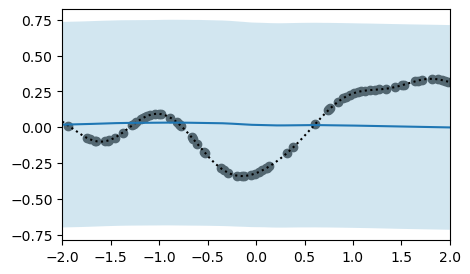

Iter: 5000, Loss 0.289260,
Iter: 10000, Loss 0.406199,
Iter: 15000, Loss 0.233306,
Iter: 20000, Loss 0.407058,


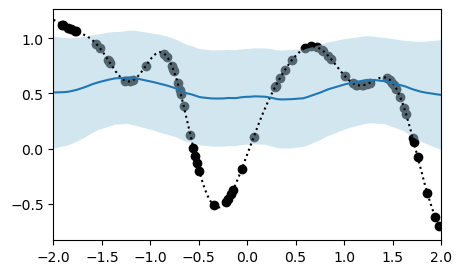

Iter: 25000, Loss -0.259763,
Iter: 30000, Loss 0.140557,
Iter: 35000, Loss 0.309043,
Iter: 40000, Loss 0.267261,


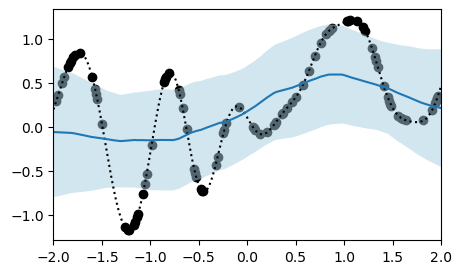

Iter: 45000, Loss 0.265461,
Iter: 50000, Loss 0.448746,
Iter: 55000, Loss 0.178626,
Iter: 60000, Loss 0.178676,


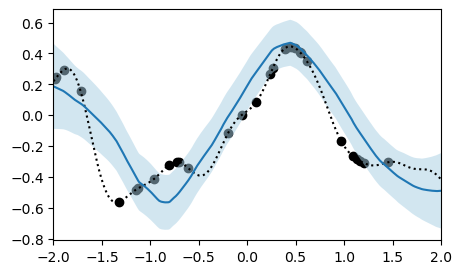

Iter: 65000, Loss 0.273029,
Iter: 70000, Loss 0.362566,
Iter: 75000, Loss 0.610216,
Iter: 80000, Loss 0.098394,


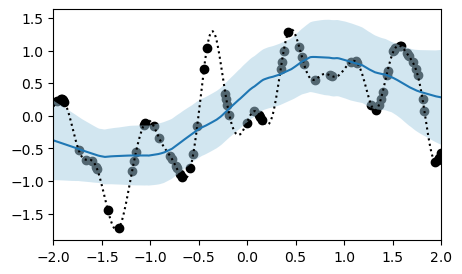

Iter: 85000, Loss -0.154972,
Iter: 90000, Loss 0.330803,
Iter: 95000, Loss 0.252082,
Iter: 100000, Loss 0.075336,


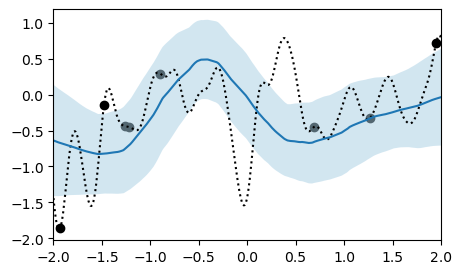

KeyboardInterrupt: 

In [96]:
from src.plot import plot_predictive
from data.sine_data import SineData
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False)
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
data = GPData(max_num_context=97, random_kernel_parameters=True, sigma_noise=0)
optimiser = torch.optim.Adam(np.parameters(), lr=1e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)

train_loss = []
for iter in range(500000+1):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss, log_p = np(batch.context_x, batch.context_y, batch.target_x, batch.target_y)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 5000 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f},") # NLL {nll:.6f}")
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

Iter: 0, Loss 0.185274,


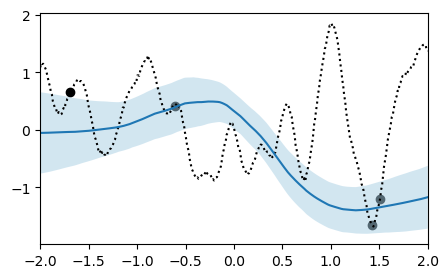

Iter: 2000, Loss 0.146268,
Iter: 4000, Loss 0.327190,
Iter: 6000, Loss 0.153948,
Iter: 8000, Loss 0.145285,
Iter: 10000, Loss 0.369234,


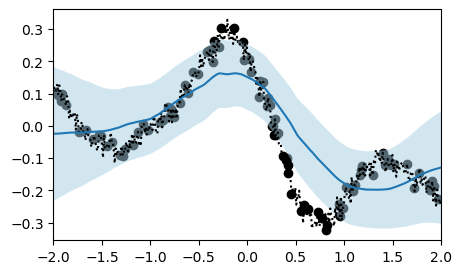

Iter: 12000, Loss 0.176327,
Iter: 14000, Loss 0.269108,
Iter: 16000, Loss 0.090595,
Iter: 18000, Loss 0.377375,
Iter: 20000, Loss 0.033304,


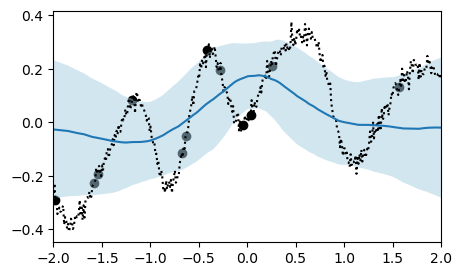

Iter: 22000, Loss 0.202196,
Iter: 24000, Loss 0.087740,
Iter: 26000, Loss 0.267508,
Iter: 28000, Loss -0.003414,
Iter: 30000, Loss 3.479977,


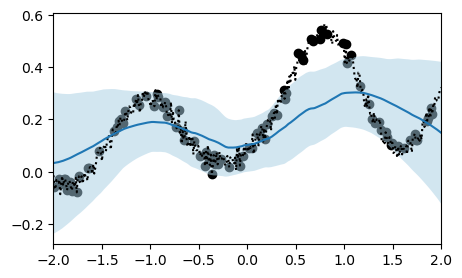

Iter: 32000, Loss 0.117013,
Iter: 34000, Loss 0.480302,
Iter: 36000, Loss 0.069447,
Iter: 38000, Loss 0.009146,
Iter: 40000, Loss 0.246935,


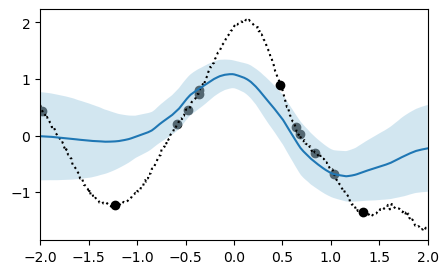

Iter: 42000, Loss 0.172183,
Iter: 44000, Loss -0.165181,
Iter: 46000, Loss 0.295920,
Iter: 48000, Loss 0.390106,
Iter: 50000, Loss 0.478753,


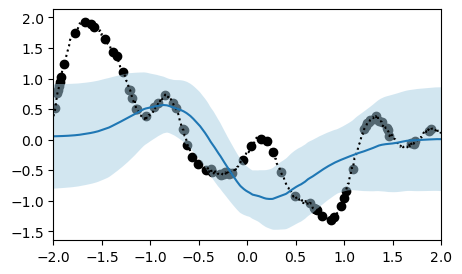

Iter: 52000, Loss 0.274593,
Iter: 54000, Loss -0.036370,
Iter: 56000, Loss 0.205005,
Iter: 58000, Loss 0.141309,
Iter: 60000, Loss 0.100577,


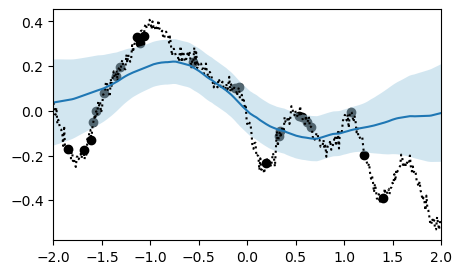

Iter: 62000, Loss 0.197895,
Iter: 64000, Loss 0.160715,
Iter: 66000, Loss 0.216158,
Iter: 68000, Loss 0.215446,


KeyboardInterrupt: 

In [37]:
for iter in range(100000+1):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss, log_p = np(batch.context_x, batch.context_y, batch.target_x, batch.target_y)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 2000 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f},") # NLL {nll:.6f}")
    if iter % 10000 == 0:
        np.training = False
        batch = data.generate_batch(1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()